In [16]:
# ----- Kernel Linear discriminant analysis -----
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlpy # mlpy is must be installed with command line function (pip, easy_install)


In [17]:
#  ----- Data Load & Preprocessing -----
data = pd.read_csv(os.path.join(os.path.join(os.path.abspath(''), os.pardir), 'C:/Users/dmqm171/Documents/R/data/Datasets_KFDA/abalone.csv'))
data = data.iloc[0:100,:]
df = pd.DataFrame.as_matrix(data)
y = df[:,0]
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'A', 2: 'I'}
X = df[:,1:]
nrow = X.shape[0]
cg = np.unique(y)
for i in range(X.shape[0]):
    if y[i] == cg[0]:
        y[i] = 1
    else:
        y[i] = 2
y = y.astype(int)


In [18]:
# ----- Define kernel & Transform function  ----- 
#Kernel function
def linear_kernel(x, y):
    return np.dot(x, y)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def rbf_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

def sigmoid_kernel(x, y, kappa, C):
    return np.tanh(kappa * np.dot(x,y) + C)

#transform original to kernel
def kernel_transform(X, kernel):
    if kernel == 'linear':
        kfunc = linear_kernel
    elif kernel == 'polynomial':
        kfunc = polynomial_kernel
    elif kernel == 'rbf':
        kfunc = rbf_kernel
    elif kernel == 'sigmoid':
        kfunc = sigmoid_kernel
    n_samples, n_features = X.shape
    n_samples = n_samples 
    n_features = n_features 
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = kfunc(X[i], X[j])            
    return K


# ----- Get a kernel matrix -----
K_mat = kernel_transform(X, 'linear')
print (K_mat.shape)


(100L, 100L)


In [19]:
# Step 1 of LDA: Computing the d-dimensional mean vectors
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,3):
    mean_vectors.append(np.mean(K_mat[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [ 169.5244   79.2167  102.3239  113.3297   79.1756   90.6423  226.0536
  181.102   102.109   214.9537  158.423   113.2016  124.629   113.5754
  113.2918  136.0115   79.2854  113.2438   79.2656  101.9345  124.1992
  112.9517  136.3626  102.431   114.1593  125.099   125.1886  136.3522
  170.1117  125.0335  113.9629  170.8683  204.2888  216.0331  148.501
   90.8273  181.6082   90.8608  125.0639  101.8116  101.9847  158.7282
   56.4742   56.4188   45.1799   79.2297  102.2002   79.5692   67.884
  102.5068   90.9917   79.3493  113.3847  113.3075   79.435    91.0579
   90.7734   90.9613   45.2623   79.734    79.5075  102.2692  113.5945
   79.4405   90.9765   90.8358  136.3291  147.9737  113.3729   67.8626
  147.3883   90.6392  226.6087  125.3939  147.801   170.1739  102.6647
  113.8862  124.9365  159.0498  102.6499  137.0905  181.3324  237.9204
  158.9168  136.6805  147.895   113.7885  102.1031  136.385   169.9271
  136.1567  147.8001  114.2741  170.7751  159.6035  102.38

In [20]:
# Step 2 of LDA: computing the Scatter matrices S_W, S_B
# within-class scatter matrix
S_W = np.zeros((nrow ,nrow))
for cl,mv in zip(range(1,3), mean_vectors):
    class_sc_mat = np.zeros((nrow,nrow))                  # scatter matrix for every class
    for row in K_mat[y == cl]:
        row, mv = row.reshape(nrow,1), mv.reshape(nrow,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

# Between-class scatter matrix Sb
overall_mean = np.mean(K_mat, axis=0)
S_B = np.zeros((nrow,nrow))
for i,mean_vec in enumerate(mean_vectors):  
    n = K_mat[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(nrow,1) # make column vector
    overall_mean = overall_mean.reshape(nrow,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
print('between-class Scatter Matrix:\n', S_B)

# ----- Find N, M, Alpha, b -----
n = nrow
idx1 = np.where(data.iloc[:,0]=='A')[0]
idx2 = np.where(data.iloc[:,0]=='I')[0]
n1 = idx1.shape[0]
n2 = idx2.shape[0]
K1, K2 = K_mat[:, idx1], K_mat[:, idx2]
N1 = np.dot(np.dot(K1, np.eye(n1) - (1 / float(n1))), K1.T)
N2 = np.dot(np.dot(K2, np.eye(n2) - (1 / float(n2))), K2.T)

#N
N = N1 + N2 + np.diag(np.repeat(0.001, n))

Ni = np.linalg.inv(N)
m1 = np.sum(K1, axis=1) / float(n1)
m2 = np.sum(K2, axis=1) / float(n2)
d = (m1 - m2)

#M
M = np.dot(d.reshape(-1, 1), d.reshape(1, -1))

#alpha
alpha = np.linalg.solve(N, d)
#alpha
b = - np.dot(alpha, (n1 * m1 + n2 * m2) / float(n))


('within-class Scatter Matrix:\n', array([[ 228791.4721,  106806.325 ,  137883.1534, ...,  122459.3087,
         107267.7219,  152923.79  ],
       [ 106806.325 ,   49860.2231,   64367.8867, ...,   57167.5645,
          50075.7157,   71389.2346],
       [ 137883.1534,   64367.8867,   83098.6368, ...,   73802.7235,
          64647.5959,   92162.255 ],
       ..., 
       [ 122459.3087,   57167.5645,   73802.7235, ...,   65546.767 ,
          57415.7122,   81852.5944],
       [ 107267.7219,   50075.7157,   64647.5959, ...,   57415.7122,
          50293.3889,   71698.7054],
       [ 152923.79  ,   71389.2346,   92162.255 , ...,   81852.5944,
          71698.7054,  102214.898 ]]))
('between-class Scatter Matrix:\n', array([[ 56106.9408,  26211.4173,  33951.7481, ...,  30135.567 ,
         26423.6586,  37593.1082],
       [ 26211.4173,  12245.1588,  15861.2005, ...,  14078.3994,
         12344.3113,  17562.3307],
       [ 33951.7481,  15861.2005,  20545.0731, ...,  18235.8041,
         1598

In [21]:
# ----- comparare  yoonsang's Alpha and package's Alpha -----

# Using linear kernel
Kl = mlpy.kernel_linear(X, X) # compute the kernel matrix
linear_kfda = mlpy.KFDA(lmb=0.001)
linear_kfda.learn(Kl, y) # compute the tranformation vector
zl = linear_kfda.transform(Kl) # embedded x into the kernel fisher space

# Using Gaussian kernel
sig = 1
Kg = mlpy.kernel_gaussian(X, X, sigma=sig) # compute the kernel matrix
gaussian_kfda = mlpy.KFDA(lmb=0.001)
gaussian_kfda.learn(Kg, y) # compute the tranformation vector
zg = gaussian_kfda.transform(Kg) # embedded x into the kernel fisher space
gaussian_kfda._coeff # alpha

# Using sigmoid kernel
gam=0.1
Ks = mlpy.kernel_sigmoid(X, X, gamma=gam, b=1.0) # compute the kernel matrix
sigmoid_kfda = mlpy.KFDA(lmb=0.001)
sigmoid_kfda.learn(Ks, y) # compute the tranformation vector
zs = sigmoid_kfda.transform(Ks) # embedded x into the kernel fisher space
print("sigmoid kfda :"sigmoid_kfda._coeff

# Using polynomial kernel
gam = 1.0
Kp = mlpy.kernel_polynomial(X, X, gamma=gam, b=1.0, d=2.0) # compute the kernel matrix
polynomial_kfda = mlpy.KFDA(lmb=0.001)
polynomial_kfda.learn(Kp, y) # compute the tranformation vector
zp = polynomial_kfda.transform(Kp) # embedded x into the kernel fisher space
polynomial_kfda._coeff


array([[-0.1198],
       [ 0.0317],
       [-0.0592],
       [ 0.0922],
       [-0.0479],
       [-0.0844],
       [ 0.0093],
       [ 0.0095],
       [ 0.1293],
       [ 0.0358],
       [ 0.0506],
       [ 0.0679],
       [-0.0224],
       [ 0.0972],
       [-0.2924],
       [-0.1886],
       [-0.3792],
       [-0.0204],
       [-0.1014],
       [ 0.0769],
       [-0.318 ],
       [-0.2501],
       [-0.0513],
       [ 0.1859],
       [-0.0396],
       [-0.2549],
       [ 0.0423],
       [-0.0995],
       [ 0.1254],
       [ 0.2395],
       [-0.2453],
       [ 0.1907],
       [ 0.038 ],
       [ 0.0127],
       [ 0.1764],
       [ 0.411 ],
       [-0.1863],
       [ 0.2005],
       [-0.1007],
       [-0.1037],
       [ 0.1786],
       [-0.1023],
       [-0.3249],
       [-0.4924],
       [-0.3259],
       [ 0.2548],
       [ 0.7057],
       [ 0.2178],
       [ 0.0261],
       [ 0.1039],
       [-0.045 ],
       [ 0.2287],
       [ 0.0965],
       [ 0.1768],
       [ 0.2243],
       [ 0

In [22]:
# Step 3 of LDA: Solving the generalized eigenvalue problem for the matrix SW−1SB
# Next, we will solve the generalized eigenvalue problem 
# for the matrix S−1W SB SW−1 SB to obtain the linear discriminants.
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(nrow,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))



Eigenvector 1: 
[[ 0.0327]
 [-0.1925]
 [ 0.0022]
 [ 0.1494]
 [-0.1073]
 [ 0.178 ]
 [-0.0128]
 [ 0.0383]
 [ 0.1081]
 [ 0.0225]
 [ 0.0451]
 [ 0.081 ]
 [-0.0993]
 [ 0.0281]
 [-0.1499]
 [-0.0501]
 [-0.0079]
 [ 0.1079]
 [-0.2811]
 [-0.0939]
 [ 0.0483]
 [-0.0494]
 [ 0.0269]
 [-0.0742]
 [ 0.1294]
 [-0.0153]
 [-0.1261]
 [ 0.0545]
 [-0.0324]
 [-0.032 ]
 [ 0.0529]
 [-0.0982]
 [-0.0056]
 [ 0.0465]
 [-0.1227]
 [ 0.1952]
 [ 0.0208]
 [ 0.0953]
 [ 0.1121]
 [ 0.0567]
 [ 0.0416]
 [ 0.0494]
 [-0.2443]
 [-0.0785]
 [-0.0464]
 [ 0.1732]
 [-0.1405]
 [-0.1306]
 [-0.1016]
 [-0.0558]
 [-0.0723]
 [-0.1334]
 [-0.1585]
 [-0.054 ]
 [-0.016 ]
 [ 0.0651]
 [-0.0112]
 [ 0.0875]
 [ 0.4024]
 [ 0.0706]
 [-0.1082]
 [-0.0566]
 [-0.0202]
 [-0.0794]
 [ 0.0728]
 [ 0.0982]
 [ 0.1145]
 [-0.0205]
 [ 0.1682]
 [-0.0281]
 [ 0.0884]
 [-0.0555]
 [-0.0423]
 [-0.0587]
 [-0.0484]
 [-0.0378]
 [ 0.1131]
 [-0.0299]
 [-0.0231]
 [ 0.0658]
 [-0.1165]
 [-0.0349]
 [-0.0352]
 [ 0.0092]
 [-0.0436]
 [ 0.0396]
 [-0.007 ]
 [-0.0056]
 [ 0.0945]
 [ 0

In [23]:
#Checking the eigenvector-eigenvalue calculation
#A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:
#Av=λv #where #A=S−1WSB #v=Eigenvector #λ=Eigenvalue

for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(nrow,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


In [24]:
# Step 4 of LDA: Selecting linear discriminants for the new feature subspace

# 4.1 sorting the eigenvectors by decreasing eigenvalues
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])
    
# 4.2 Choosing k eigenvectors with the largest eigenvalues
W = np.hstack((eig_pairs[0][1].reshape(nrow,1), eig_pairs[1][1].reshape(nrow,1)))
print('Matrix W:\n', W.real)
X_lda = K_mat.dot(W)
K_mat.dot


Eigenvalues in decreasing order:

253.432747038
253.432747038
8.61720803732
2.02095251971
1.82720183447
1.82186320813
1.82186320813
1.67785044352
1.67785044352
1.63230596574
1.63230596574
1.5715314211
1.5715314211
1.53099793186
1.53099793186
1.50801787119
1.50801787119
1.48505581502
1.48505581502
1.42736221883
1.40003223963
1.37535440741
1.37535440741
1.31025489434
1.31025489434
1.27301858262
1.27301858262
1.2499974993
1.22444852789
1.22444852789
1.20643983546
1.20643983546
1.17995240656
1.17995240656
1.14898558416
1.14898558416
1.12376830274
1.12376830274
1.07183283979
1.07183283979
1.04968964634
1.04968964634
1.04360893458
1.04360893458
1.03693218563
1.03693218563
0.973357023748
0.973357023748
0.938622285591
0.938622285591
0.915371054716
0.915371054716
0.822871901142
0.822871901142
0.772776718923
0.772776718923
0.761987042938
0.761987042938
0.692560059152
0.692560059152
0.680539635764
0.680539635764
0.679144011469
0.679144011469
0.662924328078
0.662924328078
0.657775065428
0.65777506

<function dot>

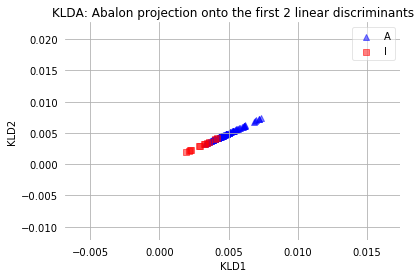

In [25]:
# Step 5: Transforming the samples onto the new subspace
X_lda = K_mat.dot(W)
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,3),('^', 's'),('blue', 'red')):

        plt.scatter(
                x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('KLD1')
    plt.ylabel('KLD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('KLDA: Abalon projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

